In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#path = "Images"
#annot = "Airplanes_Annotations"

In [3]:
path = "img"
annot = "img_anot"

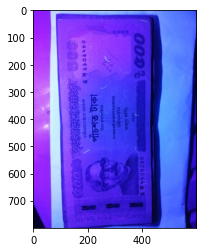

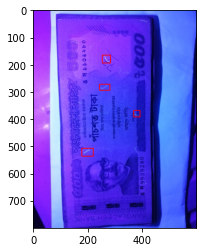

In [4]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        #filename = i.split(".")[0]+".jpg"
        #print(filename)
        filename="001.jpg"
        i="001.csv"
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255), 2)
        plt.figure()
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        break

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

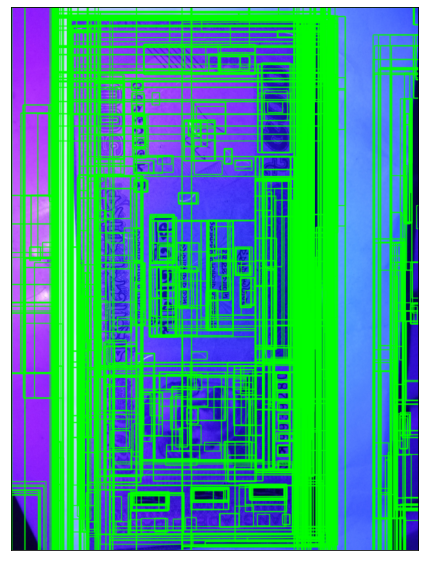

In [16]:
im = cv2.imread(os.path.join(path,"001.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.figure(figsize=(10, 10))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.imshow(cv2.cvtColor(imOut,cv2.COLOR_BGR2RGB))
plt.savefig("3.png", dpi=150)

In [10]:
train_images=[]
train_labels=[]

In [11]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith(""):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 100:
                            if iou > 0.50:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <16:
                            if iou < 0.1:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 001.jpg


In [14]:
X_test = np.array(train_images)

In [15]:
y_test = np.array(train_labels)

In [16]:
X_test.shape,y_test.shape

((21, 128, 128, 3), (21,))

In [18]:
count=0;
count_1=0;
for i in range(20):
    if y_test[i] == 1:
        count=count+1
    else :
        count_1 = count_1+1

In [19]:
count,count_1

(4, 16)

In [21]:
import pickle

pickling_on = open("X_test.pkl","wb")
pickle.dump(X_test, pickling_on)
pickling_on.close()

In [22]:
pickling_on = open("y_test.pkl","wb")
pickle.dump(y_test, pickling_on)
pickling_on.close()